Detecting Defects on biscuits
CLASSIFICATION
MODEL: MOBILENETV2
WEIGHTS: IMAGENET
OPTIMIZER: ADAM
ACTIVATION: SOFTMAX
DEEP LEARNING-TRANSFER LEARNING-CNN ALGORITHM

In [1]:
import cv2 
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [54]:
#split data
import math

# Configuration
input_root = "biscuit"          # source folder with OK & NOK
output_root = "."               # current dir (or change to e.g., "dataset_split")

# Create main split dirs
for split in ["train", "test", "val"]:
    os.makedirs(os.path.join(output_root, split, "OK"), exist_ok=True)
    os.makedirs(os.path.join(output_root, split, "NOK"), exist_ok=True)

IMG_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp"}

def copy_image(src_path, dst_path):
    """Copy image using cv2 (to stay within allowed modules)"""
    img = cv.imread(src_path)
    if img is not None:
        return cv.imwrite(dst_path, img)
    return False

# Process each class
for class_name in ["OK", "NOK"]:
    class_dir = os.path.join(input_root, class_name)
    
    # Get list of valid image filenames
    all_files = [
        f for f in os.listdir(class_dir)
        if os.path.splitext(f)[1].lower() in IMG_EXTENSIONS
    ]
    
    # Shuffle
    random.seed(42)  # for reproducibility
    random.shuffle(all_files)
    
    n = len(all_files)
    n_train = math.floor(0.8 * n)
    n_test = math.floor(0.1 * n)
    # n_val = n - n_train - n_test  # remaining ~10%

    train_files = all_files[:n_train]
    test_files = all_files[n_train:n_train + n_test]
    val_files = all_files[n_train + n_test:]

    print(f"\nClass: {class_name} | Total: {n} | Train: {len(train_files)}, Test: {len(test_files)}, Val: {len(val_files)}")

    # Copy to respective dirs
    for split_name, files in [("train", train_files), ("test", test_files), ("val", val_files)]:
        for fname in files:
            src = os.path.join(class_dir, fname)
            dst = os.path.join(output_root, split_name, class_name, fname)
            if not copy_image(src, dst):
                print(f" Failed to copy {src}")

print("\n Split complete!")
print("Directory structure created:")
print("train/OK/, train/NOK/")
print("test/OK/, test/NOK/")
print("val/OK/, val/NOK/")


Class: OK | Total: 216 | Train: 172, Test: 21, Val: 23

Class: NOK | Total: 104 | Train: 83, Test: 10, Val: 11

✅ Split complete!
Directory structure created:
train/OK/, train/NOK/
test/OK/, test/NOK/
val/OK/, val/NOK/


In [2]:
base_model= MobileNetV2(input_shape=(224,224,3),
                        include_top=False,
                        weights='imagenet')
base_model.trainable=True
for layer in base_model.layers[:-20]:
    layer.trainable=False

In [3]:
#add global pooling and dense layers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,
        activation='relu')(x)
predictions=Dense(2,      # 2 is number of classes
                  activation='softmax')(x) 
model=Model(inputs=base_model.input,
            outputs=predictions) 

In [4]:
model.compile(optimizer=Adam(learning_rate=10e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# Only rescale — no augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'biscuit_dataset/train'
val_dir = 'biscuit_dataset/val'
test_dir = 'biscuit_dataset/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),     # Optional: ensure consistency
    batch_size=32,
    class_mode='categorical',   # One-hot labels
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 255 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [6]:
print("🚀 Training classifier head only...")

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

🚀 Training classifier head only...
Epoch 1/10
8/8 [==============================] - 13s 904ms/step - loss: 0.4316 - accuracy: 0.8000 - val_loss: 1.3466 - val_accuracy: 0.6765
Epoch 2/10
8/8 [==============================] - 6s 724ms/step - loss: 0.1331 - accuracy: 0.9529 - val_loss: 1.8020 - val_accuracy: 0.6765
Epoch 3/10
8/8 [==============================] - 6s 743ms/step - loss: 0.0448 - accuracy: 0.9961 - val_loss: 2.2954 - val_accuracy: 0.6765
Epoch 4/10
8/8 [==============================] - 6s 722ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 2.8013 - val_accuracy: 0.6765
Epoch 5/10
8/8 [==============================] - 6s 722ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 3.1421 - val_accuracy: 0.6765
Epoch 6/10
8/8 [==============================] - 6s 726ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 3.2986 - val_accuracy: 0.6765
Epoch 7/10
8/8 [==============================] - 6s 728ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 3.3800 - val_a

In [7]:
print("📊 Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

📊 Evaluating on test set...
1/1 [==============================] - 1s 546ms/step - loss: 3.2593 - accuracy: 0.6774
✅ Test Accuracy: 0.6774


In [8]:
model.save('biscuit_mobilenetv2_2class_no_aug.h5')
print("✅ Model saved as 'biscuit_mobilenetv2_2class_no_aug.h5'")

C:\Users\Mahdi\anaconda3\envs\ai_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved as 'biscuit_mobilenetv2_2class_no_aug.h5'


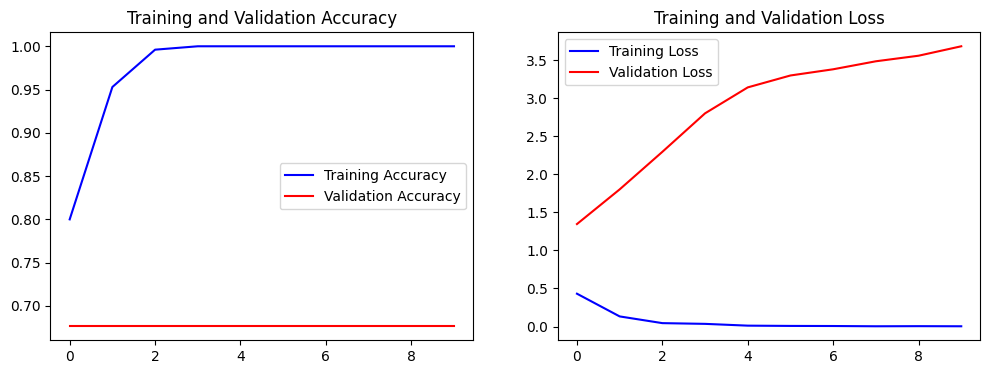

In [9]:

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)  # Initial training
# plot_history(fine_tune_history)  # If you fine-tuned